In [11]:
import pandas as pd
import csv
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt

def parse_csv(path):
    df = pd.read_csv(path)
    df['Weight'] = df['Weight'].fillna(1)
    df.dropna(axis='rows', how='any', inplace=True)
    return df['Predicate'], df['Weight']

In [12]:
# Open the full CSV
source_folder_path = "C:/Users/Sverre/Documents/UNI/2amd20/2AMD20/data"
compiled_file_source = pd.read_csv(f"{source_folder_path}/preprocessed_data.csv")

In [13]:
compiled_file_source

,Subject,Predicate,Object
0,s-Hertogenbosch,"donorRegisterValues-avg-x1000-2019Until2021,in...",0.0005505522734215995
1,s-Hertogenbosch,"donorRegisterValues-avg-x1000-2019Until2021,no...",0.0003278787278993817
2,s-Hertogenbosch,"donorRegisterValues-avg-x1000-2019Until2021,total",0.0008782158577987376
3,s-Hertogenbosch,"hasAdmissions-x10000-2019,Men,0-years",0.004543831189786706
4,s-Hertogenbosch,"hasAdmissions-x10000-2019,Men,1-20-years",0.0005034358420502317
...,...,...,...
42900,Werkendam,isPartOf,Noord-Brabant
42901,Winsum,isPartOf,Groningen
42902,Woudrichem,isPartOf,Noord-Brabant
42903,Zederik,isPartOf,Zuid-Holland


In [50]:
# Provide a CSV with the desired predicated for the to be computed ranking
predicates_path = "C:/Users/Sverre/Documents/UNI/2amd20/2AMD20"
file_name = "poster_predicates"
input_predicates = pd.read_csv(f"{predicates_path}/{file_name}.csv")

In [51]:
input_predicates

,Predicate,Weight
0,hasPopulationDensityPerSquareKm-2021,1
1,hasPopulationSize-2021,1
2,hasDepartureToAnotherMunicipality-avg-2019Unti...,1
3,hasDiseasesOfTheCardiovascularSystem-avg-2018U...,1
4,hasDiseasesOfTheRespiratorySystem-avg-2018Unti...,1
5,hasGraduatesOfDoctorate-avg-2019Until2021,-1
6,hasGraduatesOfHigherVocationalEducation-avg-20...,-1
7,hasGraduatesOfPost-SecondaryVocationalEducatio...,-1
8,hasGraduatesOfSecondaryEducation-avg-2019Until...,-1
9,hasJobsInA-AgricultureForestryFishing-avg-perc...,-1


In [52]:
# Convert the input CSV to two lists (maintaining the order)
predicates = input_predicates["Predicate"].tolist()
weights = input_predicates["Weight"].tolist()

In [49]:
def find_smallest(predicates):
    smallest = ""
    smallest_count = 10000
    for predicate in predicates:
        count = compiled_file_source.loc[compiled_file_source["Predicate"] == predicate].shape[0]
        if count < smallest_count and not count < 20: #THE COUNT < 20 CHECK IS A FAILSAFE DURING TEST
            smallest = predicate
            smallest_count = count
    return smallest, smallest_count

In [17]:
# Create the function that takes the inputted dataframe of predicates and 
def query_Rankings(predicates, weights):
    # Create a set of lists containing all applicable data to be put in a dataframe later to obtain the rankings
    get_locations_from, count = find_smallest(predicates)
    tmp = compiled_file_source.loc[compiled_file_source["Predicate"] == get_locations_from].copy()
    query_dataframe = tmp["Subject"].to_frame().copy()
    # Now go through all predicates and add the numerical columns
    for predicate in predicates:
        # Set predicate name for column naming
        col_name = predicate
        # Check whether the predicate is numerical, if not, skip
        tmp = compiled_file_source.loc[compiled_file_source["Predicate"] == predicate].copy()
        tmp.rename(columns = {'Object': col_name}, inplace = True)
        if tmp.shape[0] < count: # Temporary failsafe if column is too small
            continue
        cleaned_predicate_df = tmp.drop(["Predicate"], axis=1).copy()
        query_dataframe = query_dataframe.merge(cleaned_predicate_df, how='inner')
        # Now remove any rows containing at least one empty slot (failsafe)
        query_dataframe = query_dataframe[query_dataframe[col_name].notna()]
    # query_dataframe should now contain all >Complete< locations to be ranked
    # meaning each location has a value in all surviving numerical predicates
    # Now, rank all remaining predicates
    for predicate in query_dataframe.columns.values.tolist():
        # Skip "Subject"
        if predicate == "Subject":
            continue
        # Create a new column containing the rank for each predicate and drop the old raw data column
        query_dataframe[predicate] = query_dataframe[predicate].rank()
    # query_dataframe now contains for each subject and all provided (surviving) predicates the ranking amongst each predicate
    # Now, go through the surviving predicates and apply their weights to their ranking
    for predicate in query_dataframe.columns.values.tolist():
        # Skip "Subject"
        if predicate == "Subject":
            continue
        index = predicates.index(predicate)
        weight = weights[index]
        query_dataframe[predicate] = weight * query_dataframe[predicate]
    # Now create a final ranking consisting of the summation of all non-Subject ranks
    query_dataframe["Total_Rank"] = query_dataframe.sum(axis=1, numeric_only=True)
    # Drop the intermediate ranks for the final output
    query_ranked = query_dataframe.copy()
    for col in query_ranked.columns.values.tolist():
        if col == "Subject" or col == "Total_Rank":
            continue
        query_ranked = query_ranked.drop([col], axis=1)
    # Finally, output the subjects based on their final rank order
    query_ranked = query_ranked.sort_values("Total_Rank", ascending=True)
    query_ranked["Rank"] = query_ranked["Total_Rank"].rank()
    return query_dataframe, query_ranked

In [102]:
raw, ranking = query_Rankings(predicates, weights)

In [103]:
ranking.set_index('Rank')

,Subject,Total_Rank
Rank,,
1.0,Urk,-1128.5
2.0,Reusel-De-Mierden,-988.5
3.0,Stede-Broec,-929.0
4.0,Zeewolde,-919.5
5.0,Blaricum,-845.0
...,...,...
338.0,Landgraaf,1478.0
339.0,Sittard-Geleen,1489.5
340.0,Rheden,1523.0


In [362]:
example_relation = ["hasNumberOfUnmarried-2021"]
example_weight = [1] #, "hasDistanceToGeneralPracticeCenter-avg-km-2019Until2021"]#, "hasDistanceToHospital-avg-km-2019Until2021"]

In [368]:
def compute_Relations(relation_predicates, relation_weights, health_predicates, health_weights):
    # Compute the rankings using the provided health predicates and weights
    raw, ranking = query_Rankings(health_predicates, health_weights)
    # Create a subject-only dataframe to add the predicate data to as columns
    relation_data = raw["Subject"].to_frame().copy()
    # For each predicate, merge the data into the dataframe
    for predicate in health_predicates:
        col_name = predicate
        # Check whether the predicate is numerical, if not, skip
        tmp = compiled_file_source.loc[compiled_file_source["Predicate"] == predicate].copy()
        tmp.rename(columns = {'Object': col_name}, inplace = True)
        cleaned_predicate_df = tmp.drop(["Predicate"], axis=1).copy()
        relation_data = relation_data.merge(cleaned_predicate_df, how='inner')
    # Now loop over each predicate again and plot the relation based on all included subjects in the ranking
    relation_data = relation_data.merge(ranking, how="inner")
    
    raw1, rank1 = query_Rankings(example_relation, relation_weights)
    rank1 = rank1.rename(columns={"Rank": "Test"})
    rank1 = rank1.drop(["Total_Rank"], axis=1).copy()
    relation_data = relation_data.merge(rank1, how="inner")
    
    predicate = relation_predicates
    
    plt.figure(figsize=(5, 5), dpi=80)
    plt.scatter(relation_data["Test"].tolist(), relation_data["Rank"].tolist(),  alpha=0.5)
    #print(relation_data[predicate].astype(float), relation_data[predicate].tolist())
    #plt.xticks(np.arange(min(relation_data[predicate].astype(float)), max(relation_data[predicate].astype(float)), max(relation_data[predicate].astype(float))/5))
    #plt.xticks([])
    plt.xlabel("Attribute Ranking")
    plt.ylabel("Ranking")

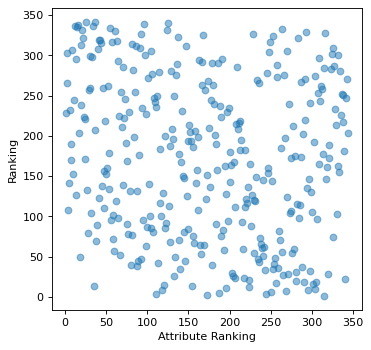

In [369]:
compute_Relations(example_relation, example_weight, predicates, weights)